In [140]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import oskar
# scripts = oskar.Scripts()
import numpy as np
from tqdm import tqdm
import numpy
import matplotlib.pyplot as plot
import sys
import pickle as pkl
# import pyvisa as visa
import pyvisa as visa
import datetime
from scipy.optimize import curve_fit

from collections import defaultdict
from scipy.stats import kurtosis, skew
import pandas as pd
# import xarray as xr
from collections import OrderedDict
from pathlib import Path
import fnmatch
import time

Connect the GPIB - usb cable to electron PC, then run this script together with the artiq zotino_calibrator script

In [2]:
interval_in_ms = 600
count = 1
number_of_pins = 32
volt_set = np.arange(-3,3.1,0.5)
# volt_set = [-2.00000000e-01, -1.80000000e-01, -1.60000000e-01, -1.40000000e-01]
# volt_set = [-1.5,-1.4,-1.3,-1.2,-1.1,-1.,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]
number_of_datapoints = len(volt_set)
volt_measure = np.zeros((number_of_pins,number_of_datapoints))
volt_set

array([-3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,
        2.5,  3. ])

In [3]:
volt_set = [-3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,
        2.5,  3. ]

# External trigger mode

connect the artiq ttl output to the external trig of the digital multimeter

In [167]:
rm = visa.ResourceManager()
instruments = rm.list_resources()
# instruments
usb = list(filter(lambda x: 'USB' in x, instruments))
if len(usb) != 1:
    print('Bad instrument list', instruments)
    sys.exit(-1)
keithley = rm.open_resource(usb[0])

In [6]:
instruments

('ASRL/dev/ttyS4::INSTR',
 'ASRL/dev/ttyS31::INSTR',
 'ASRL/dev/ttyS30::INSTR',
 'ASRL/dev/ttyS29::INSTR',
 'ASRL/dev/ttyS28::INSTR',
 'ASRL/dev/ttyS27::INSTR',
 'ASRL/dev/ttyS26::INSTR',
 'ASRL/dev/ttyS25::INSTR',
 'ASRL/dev/ttyS24::INSTR',
 'ASRL/dev/ttyS23::INSTR',
 'ASRL/dev/ttyS22::INSTR',
 'ASRL/dev/ttyS21::INSTR',
 'ASRL/dev/ttyS20::INSTR',
 'ASRL/dev/ttyS19::INSTR',
 'ASRL/dev/ttyS18::INSTR',
 'ASRL/dev/ttyS17::INSTR',
 'ASRL/dev/ttyS16::INSTR',
 'ASRL/dev/ttyS15::INSTR',
 'ASRL/dev/ttyS14::INSTR',
 'ASRL/dev/ttyS13::INSTR',
 'ASRL/dev/ttyS12::INSTR',
 'ASRL/dev/ttyS11::INSTR',
 'ASRL/dev/ttyS10::INSTR',
 'ASRL/dev/ttyS9::INSTR',
 'ASRL/dev/ttyS8::INSTR',
 'ASRL/dev/ttyS7::INSTR',
 'ASRL/dev/ttyS6::INSTR',
 'ASRL/dev/ttyS5::INSTR',
 'ASRL/dev/ttyS3::INSTR',
 'ASRL/dev/ttyS2::INSTR',
 'ASRL/dev/ttyS1::INSTR',
 'ASRL/dev/ttyS0::INSTR',
 'USB0::1510::8448::1243106::0::INSTR',
 'TCPIP::192.168.169.104::INSTR',
 'TCPIP::192.168.169.115::INSTR')

change artiq Vs manually, run this block then quickly run artiq DAC calibration 

In [127]:
keithley.query('fetch?')

KeyboardInterrupt: 

In [172]:
pin = 23 # artiq zotino channel number, the same as the zotino_channel in zotino calibrator, notice this is not Dsub pin!!
# make sure the zotino output is connected to the back ports of the keithley multimeter!
interval_in_ms = 400
for i in tqdm(range(number_of_datapoints)):
    
    keithley.write("trigger:source external")
    keithley.write("trigger:delay %f" % (interval_in_ms / 1000.0))
    keithley.write("trigger:count %d" % count)
    keithley.write("initiate")
    time.sleep(2)
    
    volt_measure[pin][i] = float(keithley.query('fetch?'))
    keithley.write("*rst; status:preset; *cls")

print(volt_measure[pin])

100%|███████████████████████████████████████████| 13/13 [00:26<00:00,  2.04s/it]

[-11.7040256   -9.7480672   -9.47600192  -5.8235456   -3.86180864
  -1.89869824   0.06388231   2.02558832   3.98818176   5.95022464
   7.47228928   9.87537088  11.8374712 ]


In [149]:
volt_measure

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.17406768e+01, -9.78072000e+00, -7.81965504e+00,
        -5.85748608e+00, -3.89625984e+00, -2.02325552e+00,
         2.73462624e-02,  1.98878768e+00,  3.94447104e+00,
         5.91208128e+00,  7.87479232e+00,  9.83582656e+00,
         1.17970120e+01],
       [-1.17470032e+01, -9.79098624e+00, -7.83033856e+00,
        -5.86828736e+00, -3.90701792e+00, -1.94526704e+00,
         1.63370992e-02,  1.97740368e+00,  3.94014080e+00,
         5.90000256e+00,  7.86238016e+00,  9.82313536e+00,
         1.17843688e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e

3.923927238681317
0.06447776541538516


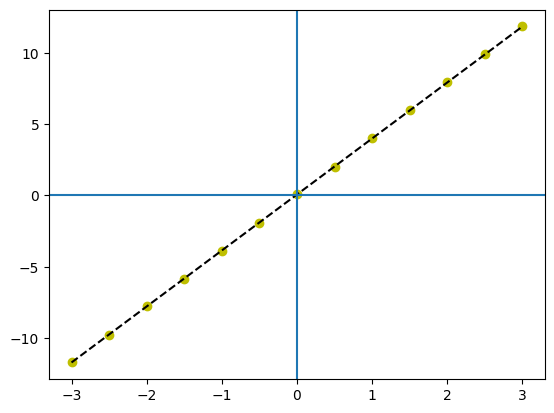

In [176]:
i = pin
m,b = np.polyfit(volt_set, volt_measure[i], 1)
print(m)
print(b)
plt.plot(volt_set, volt_measure[i], 'yo', volt_set, [m*v+b for v in volt_set], '--k',label=i)
#         plt.legend()

# plt.xlim(-0.01,0.01)
# plt.ylim(-0.01,0.01)
plt.axvline(0)
plt.axhline(0)

## Only run this if has individual error, and first run artiq calibration script w/o voltage scan

In [175]:
# pin = 2
voltage_set = 2
index = volt_set.index(voltage_set)
volt = float(keithley.query('MEAS:VOLT:DC?'))
print(volt)
measured_V = volt
volt_measure[pin][index] = measured_V

7.91252224


In [30]:
volt_measure

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [-11.74948   ,  -9.78986048,  -7.82880704,  -5.8665824 ,
         -3.90021664,  -3.75595808,   0.01836819,   1.9796832 ,
          3.69202304,   5.9031488 ,   7.86593472,   9.82688512,
         11.7881592 ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.

## Data processing

In [146]:
slope = np.ones(number_of_pins)
y0 = np.zeros(number_of_pins)
calibrated_pins = [7, 17, 1, 2, 15, 12, 25, 23, 8, 16, 19, 4, 6, 18, 10, 24, 22, 21, 13, 20, 11]

In [147]:
slope

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

array([[ 0.00000000e+00,  2.01741433e-02,  1.77115697e-02,
         0.00000000e+00,  4.98113957e-02,  0.00000000e+00,
         2.79283360e-02,  3.89202786e-04, -2.38795791e-04,
         0.00000000e+00, -1.35535924e-02, -1.49568102e-02,
         7.96655419e-03, -1.14566921e-02,  0.00000000e+00,
        -9.89205503e-03,  1.65189566e-02,  7.90919719e-02,
        -1.63685823e-02,  2.93780588e-03, -1.94182794e-02,
        -6.98033831e-03, -7.09408158e-03,  6.44777654e-02,
         3.78554489e-02,  7.46475289e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  3.92405343e+00,  3.50891903e+00,
         1.00000000e+00,  3.92203426e+00,  1.00000000e+00,
         3.92179051e+00,  3.92195172e+00,  3.92321577e+00,
         1.00000000e+00,  3.92418316e+00,  3.92330356e+00,
         3.92356233e+00,  3.92243722e+00,  1.00000000e+00,
         3.91689792e+00,  3.92359958e+00,  3.92304961e+00,
         3.92

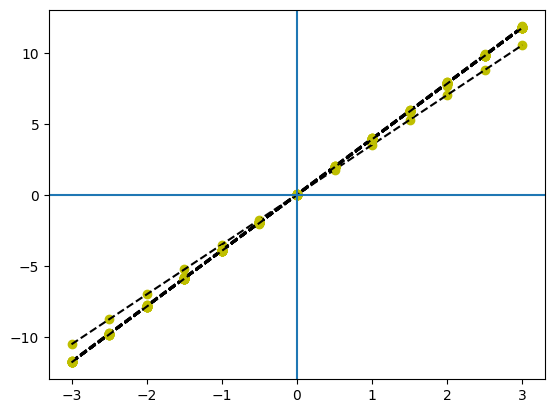

In [177]:
# slope = []
# y0 = []
for i,pin in enumerate(calibrated_pins):
    m,b = np.polyfit(volt_set, volt_measure[pin], 1)
    slope[pin] = m
    y0[pin] = b
    plt.plot(volt_set, volt_measure[pin], 'yo', volt_set, [m*v+b for v in volt_set], '--k',label=pin)
#         plt.legend()

# plt.xlim(-0.01,0.01)
# plt.ylim(-0.01,0.01)
plt.axvline(0)
plt.axhline(0)

fits = np.array([y0,slope])
np.savetxt('zotino_calibration_3layer_smaller_spacer_with_amp_1Mcorrection2.txt',fits)
fits

# Test reading file

In [166]:
f = 'zotino_calibration_3layer_smaller_spacer_with_amp_1Mcorrection.txt'
tmp = np.loadtxt(f)
tmp
tmp
# offset = np.zeros((tmp.shape[0],tmp.shape[1]+1))
# for i in range(tmp.shape[0]):
#     a = np.append(tmp[i],tmp[i][-1])
#     offset[i] = a
# self.dac_calibration_fit = offset

array([[ 0.00000000e+00,  2.01741433e-02, -2.72211532e-02,
         0.00000000e+00,  4.98113957e-02,  0.00000000e+00,
         2.79283360e-02,  3.89202786e-04, -2.38795791e-04,
         0.00000000e+00, -1.35535924e-02, -1.49568102e-02,
         7.96655419e-03, -1.14566921e-02,  0.00000000e+00,
        -9.89205503e-03,  1.65189566e-02,  7.90919719e-02,
        -1.63685823e-02,  2.93780588e-03, -1.94182794e-02,
        -6.98033831e-03, -7.09408158e-03, -4.67510774e-02,
         3.78554489e-02,  7.46475289e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  3.92405343e+00,  3.50885124e+00,
         1.00000000e+00,  3.92203426e+00,  1.00000000e+00,
         3.92179051e+00,  3.92195172e+00,  3.92321577e+00,
         1.00000000e+00,  3.92418316e+00,  3.92330356e+00,
         3.92356233e+00,  3.92243722e+00,  1.00000000e+00,
         3.91689792e+00,  3.92359958e+00,  3.92304961e+00,
         3.92

In [105]:
f = open('Cfile_3layer.txt','r')
# create list of lines from selected textfile
list_of_lists = []
for line in f:
    stripped_line = line.strip()
    line_list = stripped_line.split()
    list_of_lists.append(float(line_list[0]))
#     print(line_list)